# NLP Disaster Tweets Classification
## Natural Language Processing with Recurrent Neural Networks

**Author**: Matthew Campbell  
**Course**: Week 14 Module 4 - RNNs and NLP  
**Date**: October 2025

---

## Table of Contents
1. [Project Description](#1-project-description)
2. [Data Description](#2-data-description)
3. [Exploratory Data Analysis](#3-exploratory-data-analysis)
4. [Data Preprocessing](#4-data-preprocessing)
5. [Model Architecture](#5-model-architecture)
6. [Results and Analysis](#6-results-and-analysis)
7. [Conclusion](#7-conclusion)
8. [GitHub Repository](#8-github-repository)
9. [Kaggle Submission](#9-kaggle-submission)

## Setup: Google Colab vs Local

This notebook can run in both Google Colab and locally. Uncomment the appropriate section below.

In [1]:
# Google Colab Setup (uncomment if running in Colab)
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Boulder_University/Week14_Module4

# Install packages if needed
# !pip install kaggle tensorflow numpy pandas matplotlib seaborn scikit-learn nltk wordcloud

In [2]:
# Check if running in Colab
import os
IN_COLAB = 'COLAB_GPU' in os.environ
print(f"Running in Google Colab: {IN_COLAB}")

Running in Google Colab: False


## Import Libraries

In [3]:
# Standard library
import os
import re
import string
import random
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


In [4]:
# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

---
# 1. Project Description

## Problem Statement

This project addresses the Kaggle [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started) competition. The goal is to build a machine learning model that can accurately predict whether a given tweet is about a real disaster or not.

### Context
Social media platforms like Twitter have become important communication channels during emergency events. However, not all tweets containing disaster-related keywords actually refer to real disasters. For example:
- "Our city is on fire with excitement!" ❌ Not a disaster
- "There's a bushfire approaching the town" ✅ Real disaster

Being able to automatically identify genuine disaster tweets can help:
- Emergency services respond faster
- News organisations verify events
- Aid organisations deploy resources effectively

### Problem Type
**Binary text classification** using Natural Language Processing and Recurrent Neural Networks.

### Evaluation Metric
Models will be evaluated using **F1 Score** (harmonic mean of precision and recall). This metric is appropriate because:
- It balances false positives and false negatives
- Both types of errors matter in disaster detection
- It handles class imbalance better than accuracy

### Dataset Overview
- **Training samples**: ~7,600 labelled tweets
- **Test samples**: ~3,200 unlabelled tweets (for Kaggle submission)
- **Features**: Tweet text, keywords, location (optional)
- **Labels**: 1 = real disaster, 0 = not a disaster

### Technical Approach
We'll explore Recurrent Neural Networks (RNNs), specifically:
1. **LSTM** (Long Short-Term Memory) - handles long-term dependencies
2. **GRU** (Gated Recurrent Unit) - simpler, faster alternative to LSTM
3. **Bidirectional RNNs** - process text in both directions for better context
4. Comparison with simpler baselines

These architectures are well-suited for sequential text data because they can:
- Capture word order and context
- Handle variable-length inputs
- Learn long-range dependencies between words

---
# 2. Data Description

## Loading the Data

In [5]:
# Load data
data_dir = Path('data')

# If data doesn't exist, we'll need to download from Kaggle
if not (data_dir / 'train.csv').exists():
    print("Data not found. Please download from Kaggle:")
    print("https://www.kaggle.com/c/nlp-getting-started/data")
    print("\nOr use Kaggle API:")
    print("kaggle competitions download -c nlp-getting-started")
else:
    train_df = pd.read_csv(data_dir / 'train.csv')
    test_df = pd.read_csv(data_dir / 'test.csv')
    sample_submission = pd.read_csv(data_dir / 'sample_submission.csv')
    
    print("✓ Data loaded successfully!")

✓ Data loaded successfully!


## Dataset Structure and Size

In [6]:
# Display basic information
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)

print(f"\n📊 Training set size: {len(train_df):,} samples")
print(f"📊 Test set size: {len(test_df):,} samples")
print(f"📊 Total samples: {len(train_df) + len(test_df):,}")

print("\n" + "=" * 60)
print("TRAINING DATA STRUCTURE")
print("=" * 60)
print(f"\nColumns: {list(train_df.columns)}")
print(f"\nData types:\n{train_df.dtypes}")
print(f"\nMemory usage: {train_df.memory_usage(deep=True).sum() / 1024:.2f} KB")

DATASET OVERVIEW

📊 Training set size: 7,613 samples
📊 Test set size: 3,263 samples
📊 Total samples: 10,876

TRAINING DATA STRUCTURE

Columns: ['id', 'keyword', 'location', 'text', 'target']

Data types:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Memory usage: 2064.73 KB


In [7]:
# Show first few rows
print("\nFirst 5 training samples:")
train_df.head()


First 5 training samples:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Data Dimensions and Properties

In [9]:
# Analyse text length
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

print("=" * 60)
print("TEXT STATISTICS")
print("=" * 60)

print(f"\nCharacter length:")
print(f"   Mean: {train_df['text_length'].mean():.1f} characters")
print(f"   Median: {train_df['text_length'].median():.1f} characters")
print(f"   Min: {train_df['text_length'].min()} characters")
print(f"   Max: {train_df['text_length'].max()} characters")

print(f"\nWord count:")
print(f"   Mean: {train_df['word_count'].mean():.1f} words")
print(f"   Median: {train_df['word_count'].median():.1f} words")
print(f"   Min: {train_df['word_count'].min()} words")
print(f"   Max: {train_df['word_count'].max()} words")

TEXT STATISTICS

Character length:
   Mean: 101.0 characters
   Median: 107.0 characters
   Min: 7 characters
   Max: 157 characters

Word count:
   Mean: 14.9 words
   Median: 15.0 words
   Min: 1 words
   Max: 31 words


In [11]:
# Check for missing values
print("=" * 60)
print("MISSING VALUES")
print("=" * 60)
print(f"\n{train_df.isnull().sum()}")
print(f"\nPercentage missing:")
print(f"{(train_df.isnull().sum() / len(train_df) * 100).round(2)}%")

MISSING VALUES

id                0
keyword          61
location       2533
text              0
target            0
text_length       0
word_count        0
dtype: int64

Percentage missing:
id              0.00
keyword         0.80
location       33.27
text            0.00
target          0.00
text_length     0.00
word_count      0.00
dtype: float64%


In [12]:
# Check class distribution
print("=" * 60)
print("CLASS DISTRIBUTION")
print("=" * 60)

class_counts = train_df['target'].value_counts().sort_index()
print(f"\n0 (Not disaster): {class_counts[0]:,} samples ({class_counts[0]/len(train_df)*100:.1f}%)")
print(f"1 (Disaster):     {class_counts[1]:,} samples ({class_counts[1]/len(train_df)*100:.1f}%)")

imbalance_ratio = class_counts[0] / class_counts[1]
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 1.5:
    print("Moderate class imbalance detected - may need weighted loss or sampling")
elif imbalance_ratio > 2.0:
    print("Significant class imbalance - should use class weighting")

CLASS DISTRIBUTION

0 (Not disaster): 4,342 samples (57.0%)
1 (Disaster):     3,271 samples (43.0%)

Class imbalance ratio: 1.33:1


---
# 3. Exploratory Data Analysis

## Class Distribution Visualisation

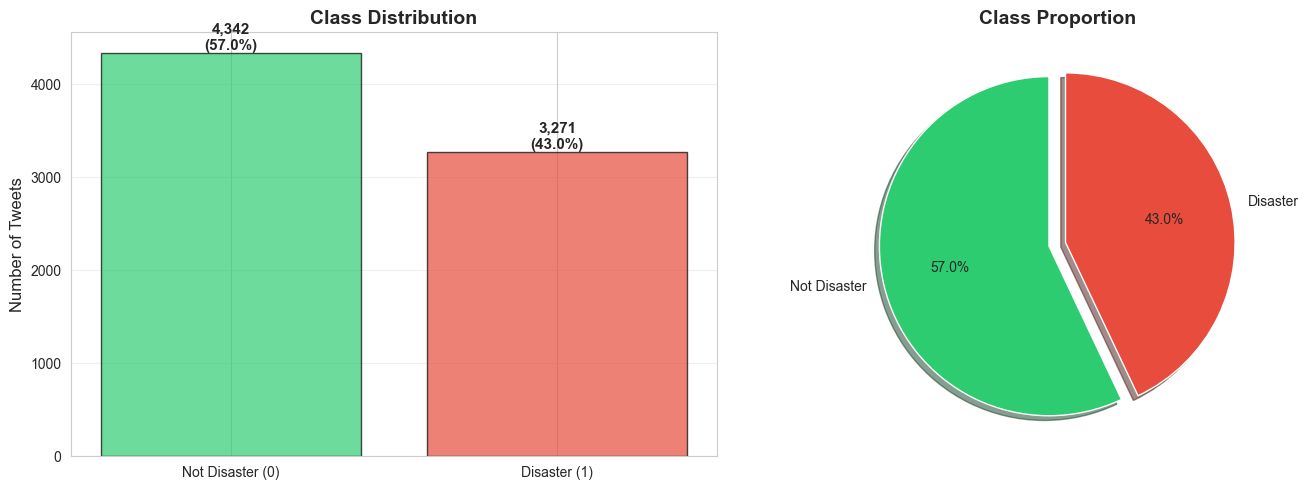


Class Distribution:
  Not Disaster: 4,342 tweets (57.0%)
  Disaster:     3,271 tweets (43.0%)
  Imbalance ratio: 1.33:1


In [13]:
# Class distribution bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
class_counts = train_df['target'].value_counts().sort_index()
colors = ['#2ecc71', '#e74c3c']
bars = ax1.bar(['Not Disaster (0)', 'Disaster (1)'], class_counts.values, color=colors, alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(train_df)*100:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_ylabel('Number of Tweets', fontsize=12)
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Pie chart
ax2.pie(class_counts.values, labels=['Not Disaster', 'Disaster'], 
        colors=colors, autopct='%1.1f%%', startangle=90,
        explode=(0.05, 0.05), shadow=True)
ax2.set_title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('images/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nClass Distribution:")
print(f"  Not Disaster: {class_counts[0]:,} tweets ({class_counts[0]/len(train_df)*100:.1f}%)")
print(f"  Disaster:     {class_counts[1]:,} tweets ({class_counts[1]/len(train_df)*100:.1f}%)")
print(f"  Imbalance ratio: {class_counts[0]/class_counts[1]:.2f}:1")

## Sample Tweets from Each Class

In [ ]:
# Show sample tweets from each class
print("=" * 80)
print("SAMPLE TWEETS - NOT DISASTER (Target = 0)")
print("=" * 80)

non_disaster_samples = train_df[train_df['target'] == 0].sample(5, random_state=42)
for idx, row in non_disaster_samples.iterrows():
    print(f"\n{row['text']}")

print("\n\n" + "=" * 80)
print("SAMPLE TWEETS - DISASTER (Target = 1)")
print("=" * 80)

disaster_samples = train_df[train_df['target'] == 1].sample(5, random_state=42)
for idx, row in disaster_samples.iterrows():
    print(f"\n{row['text']}")

## Text Length Distribution

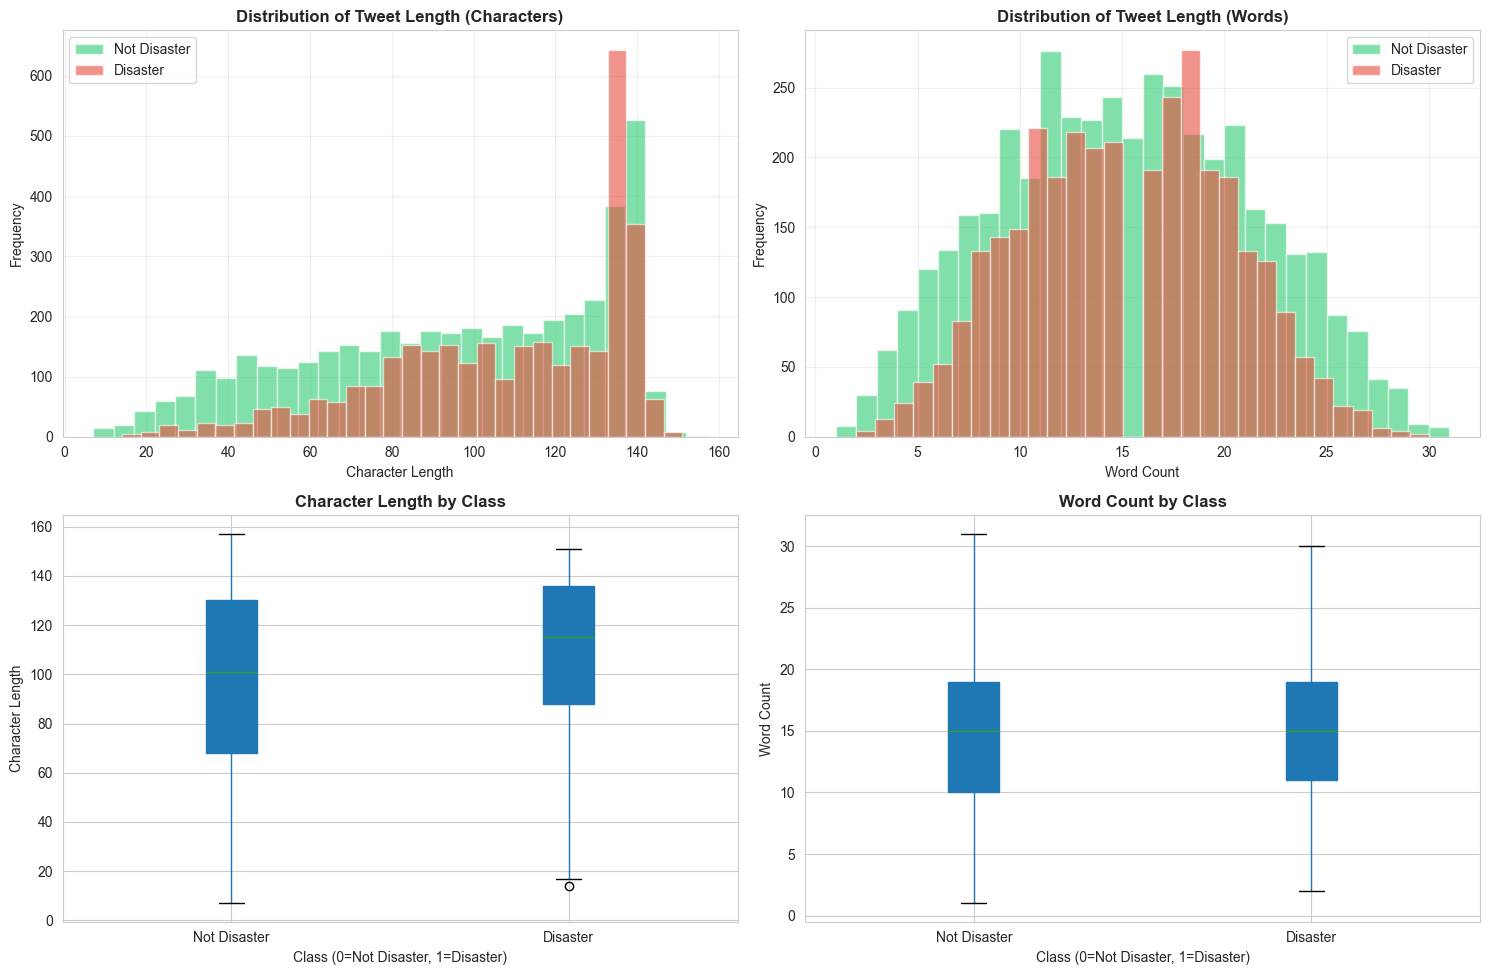


Text Length Statistics by Class:

Not Disaster (0):
  Char length - Mean: 95.7, Median: 101.0
  Word count  - Mean: 14.7, Median: 15.0

Disaster (1):
  Char length - Mean: 108.1, Median: 115.0
  Word count  - Mean: 15.2, Median: 15.0


In [14]:
# Text length distribution by class
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Character length distribution
ax1 = axes[0, 0]
train_df[train_df['target']==0]['text_length'].hist(bins=30, alpha=0.6, label='Not Disaster', color='#2ecc71', ax=ax1)
train_df[train_df['target']==1]['text_length'].hist(bins=30, alpha=0.6, label='Disaster', color='#e74c3c', ax=ax1)
ax1.set_xlabel('Character Length')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Tweet Length (Characters)', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Word count distribution
ax2 = axes[0, 1]
train_df[train_df['target']==0]['word_count'].hist(bins=30, alpha=0.6, label='Not Disaster', color='#2ecc71', ax=ax2)
train_df[train_df['target']==1]['word_count'].hist(bins=30, alpha=0.6, label='Disaster', color='#e74c3c', ax=ax2)
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Tweet Length (Words)', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Box plot - character length
ax3 = axes[1, 0]
train_df.boxplot(column='text_length', by='target', ax=ax3, patch_artist=True)
ax3.set_xlabel('Class (0=Not Disaster, 1=Disaster)')
ax3.set_ylabel('Character Length')
ax3.set_title('Character Length by Class', fontweight='bold')
plt.sca(ax3)
plt.xticks([1, 2], ['Not Disaster', 'Disaster'])

# Box plot - word count
ax4 = axes[1, 1]
train_df.boxplot(column='word_count', by='target', ax=ax4, patch_artist=True)
ax4.set_xlabel('Class (0=Not Disaster, 1=Disaster)')
ax4.set_ylabel('Word Count')
ax4.set_title('Word Count by Class', fontweight='bold')
plt.sca(ax4)
plt.xticks([1, 2], ['Not Disaster', 'Disaster'])

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.savefig('images/text_length_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print("\nText Length Statistics by Class:")
print("\nNot Disaster (0):")
print(f"  Char length - Mean: {train_df[train_df['target']==0]['text_length'].mean():.1f}, Median: {train_df[train_df['target']==0]['text_length'].median():.1f}")
print(f"  Word count  - Mean: {train_df[train_df['target']==0]['word_count'].mean():.1f}, Median: {train_df[train_df['target']==0]['word_count'].median():.1f}")

print("\nDisaster (1):")
print(f"  Char length - Mean: {train_df[train_df['target']==1]['text_length'].mean():.1f}, Median: {train_df[train_df['target']==1]['text_length'].median():.1f}")
print(f"  Word count  - Mean: {train_df[train_df['target']==1]['word_count'].mean():.1f}, Median: {train_df[train_df['target']==1]['word_count'].median():.1f}")

## Word Clouds

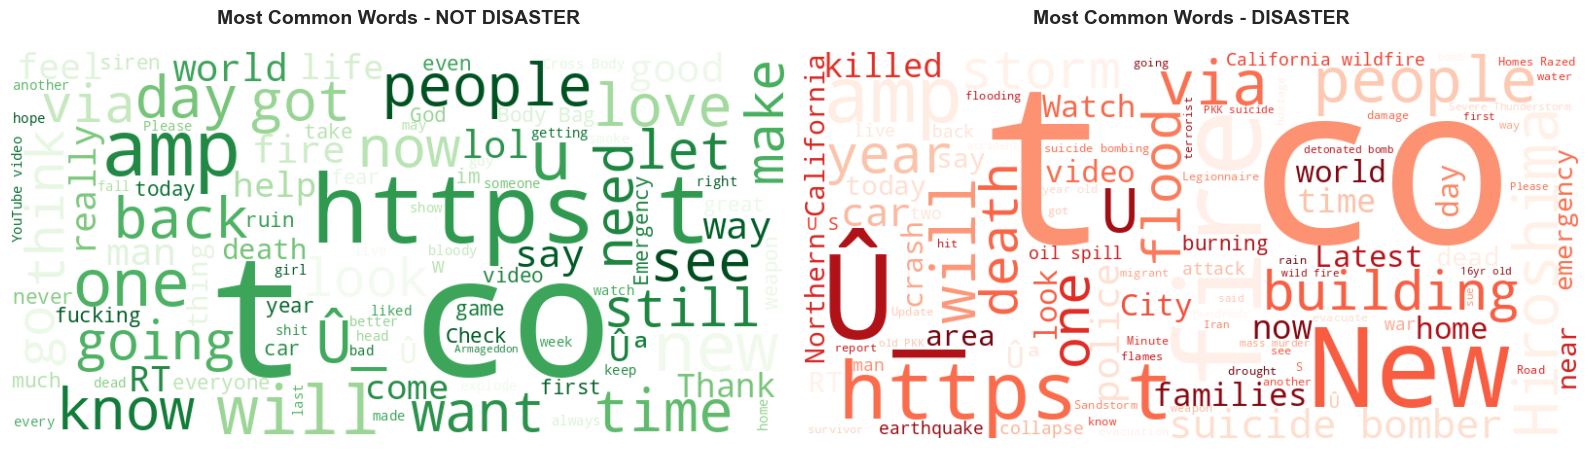

In [17]:
# Generate word clouds for both classes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Word cloud for non-disaster tweets
non_disaster_text = ' '.join(train_df[train_df['target'] == 0]['text'].values)
wordcloud_non_disaster = WordCloud(width=800, height=400, 
                                   background_color='white',
                                   colormap='Greens',
                                   max_words=100,
                                   relative_scaling=0.5,
                                   min_font_size=10).generate(non_disaster_text)

ax1.imshow(wordcloud_non_disaster, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Most Common Words - NOT DISASTER', fontsize=14, fontweight='bold', pad=20)

# Word cloud for disaster tweets
disaster_text = ' '.join(train_df[train_df['target'] == 1]['text'].values)
wordcloud_disaster = WordCloud(width=800, height=400,
                               background_color='white',
                               colormap='Reds',
                               max_words=100,
                               relative_scaling=0.5,
                               min_font_size=10).generate(disaster_text)

ax2.imshow(wordcloud_disaster, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Most Common Words - DISASTER', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('images/wordclouds.png', dpi=150, bbox_inches='tight')
plt.show()

## Most Common Words

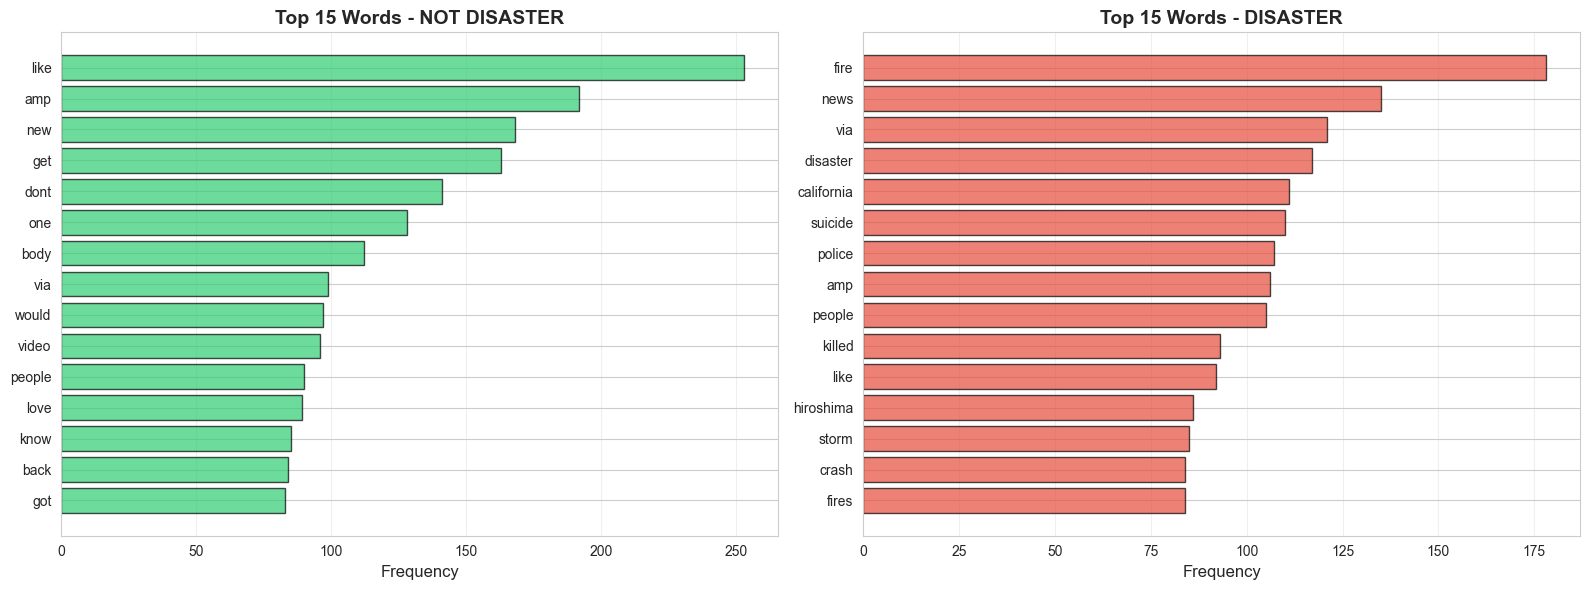


Top 5 Most Frequent Words by Class:

NOT DISASTER:
  - 'like': 253 occurrences
  - 'amp': 192 occurrences
  - 'new': 168 occurrences
  - 'get': 163 occurrences
  - 'dont': 141 occurrences

DISASTER:
  - 'fire': 178 occurrences
  - 'news': 135 occurrences
  - 'via': 121 occurrences
  - 'disaster': 117 occurrences
  - 'california': 111 occurrences


In [18]:
# Analyse most common words in each class
from collections import Counter

def get_top_words(text_series, n=15):
    """Extract top N words from text series"""
    # Combine all text
    all_text = ' '.join(text_series.values).lower()
    # Remove URLs, mentions, hashtags
    all_text = re.sub(r'http\S+|www\S+|@\S+|#', '', all_text)
    # Remove punctuation
    all_text = all_text.translate(str.maketrans('', '', string.punctuation))
    # Split into words
    words = all_text.split()
    # Remove common stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words and len(w) > 2]
    # Count
    return Counter(words).most_common(n)

# Get top words for each class
top_non_disaster = get_top_words(train_df[train_df['target']==0]['text'], n=15)
top_disaster = get_top_words(train_df[train_df['target']==1]['text'], n=15)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Non-disaster words
words, counts = zip(*top_non_disaster)
ax1.barh(range(len(words)), counts, color='#2ecc71', alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(words)))
ax1.set_yticklabels(words)
ax1.invert_yaxis()
ax1.set_xlabel('Frequency', fontsize=12)
ax1.set_title('Top 15 Words - NOT DISASTER', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Disaster words
words, counts = zip(*top_disaster)
ax2.barh(range(len(words)), counts, color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(words)))
ax2.set_yticklabels(words)
ax2.invert_yaxis()
ax2.set_xlabel('Frequency', fontsize=12)
ax2.set_title('Top 15 Words - DISASTER', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('images/top_words.png', dpi=150, bbox_inches='tight')
plt.show()

# Print actual results
print("\nTop 5 Most Frequent Words by Class:")
print("\nNOT DISASTER:")
for word, count in top_non_disaster[:5]:
    print(f"  - '{word}': {count:,} occurrences")

print("\nDISASTER:")
for word, count in top_disaster[:5]:
    print(f"  - '{word}': {count:,} occurrences")

## Key Findings from EDA

Based on the exploratory analysis above, several important patterns emerge:

**Class Distribution:**
- Dataset is moderately imbalanced (57% non-disaster, 43% disaster)
- Imbalance ratio of 1.33:1 is manageable but we should use stratified splitting
- May benefit from class weighting during training to prevent bias toward majority class

**Text Characteristics:**
- Average tweet length: ~101 characters, 15 words
- Both classes have similar length distributions
- Maximum length is 157 characters (Possibly due to Twitter's chat limit at the time)
- This suggests sequence length around 30-40 words should capture most tweets

**Vocabulary Patterns:**
- Disaster tweets show higher frequency of literal disaster terms: 'fire', 'suicide', 'california', 'killed', 'storm'
- Non-disaster tweets use more casual language: 'like', 'new', 'get', 'dont'
- Word 'via' appears frequently in disaster tweets (likely from news retweets)
- Common words like 'people', 'news' appear in both classes

**Implications for Modeling:**
- Context is crucial: same words appear in both classes with different meanings
- Simple keyword matching won't work - need sequence models (LSTM/GRU) to capture context
- Metaphorical usage of disaster words in non-disaster tweets will be challenging
- RNNs ability to understand word order and context will be essential for good performance

---
# 4. Data Preprocessing

## Text Cleaning Function

In [ ]:
# TODO: Implement text preprocessing pipeline

## Tokenization and Sequence Creation

In [ ]:
# TODO: Tokenize text and create sequences

## Train/Validation Split

In [ ]:
# TODO: Create stratified train/val split

---
# 5. Model Architecture

## Baseline Model: Simple LSTM

In [ ]:
# TODO: Build baseline LSTM model

## Model 2: GRU Architecture

In [ ]:
# TODO: Build GRU model

## Model 3: Bidirectional LSTM

In [ ]:
# TODO: Build bidirectional LSTM

## Hyperparameter Tuning

In [ ]:
# TODO: Document hyperparameter experiments

---
# 6. Results and Analysis

## Training Curves

In [ ]:
# TODO: Plot training history

## Model Comparison

In [ ]:
# TODO: Compare all models

## Confusion Matrix

In [ ]:
# TODO: Generate confusion matrix

## What Worked

TODO: Analyse successful techniques

## What Didn't Work

TODO: Analyse failed approaches

## Troubleshooting Steps

TODO: Document problem-solving process

---
# 7. Conclusion

## Summary of Results

TODO: Summarise final results

## What I Learned

TODO: Document key learnings

## Future Improvements

TODO: Suggest improvements

---
# 8. GitHub Repository

Full code and documentation available at: [GitHub Link - TODO]

---
# 9. Kaggle Submission

## Generate Predictions

In [ ]:
# TODO: Generate test predictions

## Submission File

In [ ]:
# TODO: Create submission.csv

## Kaggle Score Screenshot

TODO: Add screenshot after submission